In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

np.random.seed(98765)

In [2]:
# ELEC2 data set
# downloaded from https://www.kaggle.com/yashsharan/the-elec2-dataset
# following the same process for data pre-processing described in https://arxiv.org/pdf/2202.13415.pdf 

data = pd.read_csv('data/electricity-normalized.csv')
col_names = data.columns
data = data.to_numpy()

# remove the first stretch of time where 'transfer' does not vary
data = data[17760:]

# set up variables for the task (predicting 'transfer')
covariate_col = ['nswprice', 'nswdemand', 'vicprice', 'vicdemand']
response_col = 'transfer'
# keep data points for 9:00am - 12:00pm
keep_rows = np.where((data[:,2]>data[17,2])&(data[:,2]<data[24,2]))[0]

X = data[keep_rows][:,np.where([t in covariate_col for t in col_names])[0]]
Y = data[keep_rows][:,np.where(col_names==response_col)[0]].flatten()
X = X.astype('float64')
Y = Y.astype('float64')

N = X.shape[0]; p = X.shape[1]; alpha = 0.1
train_lag = 200 # start predicting after train_lag many observations

# randomly permuted data 
perm = np.random.choice(N,N,replace=False)
X_perm = X[perm]
Y_perm = Y[perm]

# weights and tags (parameters for new methods)
rho = 0.99; rho_LS = 0.99

In [5]:
# split conformal risk control with least squares

def split_CRC_LS(X,Y,x,alpha,weights=[],tags=[]):
    # weights are used for computing quantiles for the prediction interval
    # tags are used as weights in weighted least squares regression
    n = len(Y)
    
    loss_beta = 1.0 #loss upper bound
    
    
    lambdas = np.arange(0,2,0.01) #set lambdas range (lambda*2)
    
    if(len(tags)==0):
        tags = np.ones(n+1)
    if(len(weights)==0):
        weights = np.ones(n+1)
    if(len(weights)==n):
        weights = np.r_[weights,1]
    
    # odd data points for training, even for calibration
    inds_odd = np.arange(1,int(np.ceil(n/2)*2-1),2)
    inds_even = np.arange(2,int(np.floor(n/2)*2),2)
    
    # train model
    betahat = np.linalg.solve((X[inds_odd].T*tags[inds_odd]).dot(X[inds_odd]),\
                          (X[inds_odd].T*tags[inds_odd]).dot(Y[inds_odd]))
    
   
    # get predictions on test set
    Y_pred = X[inds_even].dot(betahat)
    
    # compute residuals 
    residuals = np.abs(Y[inds_even] - Y_pred)
    
    # compute weighted empirical risk in the calibration set
    losses = np.zeros((len(lambdas), len(residuals)))
    n_w = np.sum(weights[inds_even] )
    r_hats = np.zeros(len(lambdas))
    
    for li,l in enumerate(lambdas):
        losses[li,:]=np.maximum(np.zeros((residuals.shape)),residuals-(l/2))
        ws = np.sum(weights[inds_even]*losses[li])
        r_hats[li] = (1/n_w) * ws
        
    calib_lambdas = (r_hats*n_w/(n_w+1)) + loss_beta/(n_w+1)
   
    lambda_chosen = np.max(lambdas)
    
    # find the infimum of lambdas
    for i,li in enumerate(calib_lambdas):
        if li<=alpha:
            lambda_chosen = lambdas[i]
            break
        
    
    y_PI = np.array([x.T.dot(betahat)-(lambda_chosen/2),x.T.dot(betahat)+(lambda_chosen/2)])
    
    return lambda_chosen, y_PI


In [6]:
# set alpha 
alpha_risk = 0.05


In [7]:

# run all methods


lambdas_chosen = np.zeros((3,N))
lambdas_chosen_perm = np.zeros((3,N))
PI_CRC_LS = np.zeros((N,2))
PI_CRC_LS[:train_lag,0]=-np.inf;PI_CRC_LS[:train_lag,1]=np.inf
PI_CRC_LS = np.zeros((N,2))
PI_CRC_LS[:train_lag,0]=-np.inf;PI_CRC_LS[:train_lag,1]=np.inf
PI_nexCRC_LS = np.copy(PI_CRC_LS)
PI_nexCRC_WLS = np.copy(PI_CRC_LS)
PI_CRC_LS_perm = np.copy(PI_CRC_LS)
PI_nexCRC_LS_perm = np.copy(PI_CRC_LS)
PI_nexCRC_WLS_perm = np.copy(PI_CRC_LS)

for n in np.arange(train_lag,N):
    if n%1000==0:
        print(alpha_risk,n)
    weights=rho**(np.arange(n,0,-1))
    tags=rho_LS**(np.arange(n,-1,-1))
    lambdas_chosen[0,n],PI_CRC_LS[n,:] = split_CRC_LS(X[:n,:],Y[:n],X[n,:],alpha_risk)
    lambdas_chosen_perm[0,n],PI_CRC_LS_perm[n,:] = split_CRC_LS(X_perm[:n,:],Y_perm[:n],X_perm[n,:],alpha_risk)

    lambdas_chosen[1,n],PI_nexCRC_LS[n,:] = split_CRC_LS(X[:n,:],Y[:n],X[n,:],alpha_risk,weights=weights)
    lambdas_chosen_perm[1,n],PI_nexCRC_LS_perm[n,:] = split_CRC_LS(X_perm[:n,:],Y_perm[:n],X_perm[n,:],alpha_risk,weights=weights)
    lambdas_chosen[2,n],PI_nexCRC_WLS[n,:] = split_CRC_LS(X[:n,:],Y[:n],X[n,:],alpha_risk,weights=weights,tags=tags)
    lambdas_chosen_perm[2,n],PI_nexCRC_WLS_perm[n,:] = split_CRC_LS(X_perm[:n,:],Y_perm[:n],X_perm[n,:],alpha_risk,weights=weights,tags=tags)
    

0.05 1000
0.05 2000
0.05 3000


In [10]:
zero = np.zeros((len(PI_CRC_LS[train_lag:])))
loss_CRC_LS_dist = np.minimum(np.abs(PI_CRC_LS[train_lag:,0]-Y[train_lag:]),np.abs(PI_CRC_LS[train_lag:,1]-Y[train_lag:]))
loss_CRC_LS_inside = (np.abs(np.minimum(PI_CRC_LS[train_lag:,1]-Y[train_lag:],zero))+np.abs(np.minimum(Y[train_lag:]-PI_CRC_LS[train_lag:,0],zero)))
loss_CRC_LS = np.minimum(loss_CRC_LS_inside,loss_CRC_LS_dist)

loss_CRC_LS_dist_perm = np.minimum(np.abs(PI_CRC_LS_perm[train_lag:,0]-Y_perm[train_lag:]),np.abs(PI_CRC_LS_perm[train_lag:,1]-Y_perm[train_lag:]))
loss_CRC_LS_inside_perm = (np.abs(np.minimum(PI_CRC_LS_perm[train_lag:,1]-Y_perm[train_lag:],zero))+np.abs(np.minimum(Y_perm[train_lag:]-PI_CRC_LS_perm[train_lag:,0],zero)))
loss_CRC_LS_perm = np.minimum(loss_CRC_LS_inside_perm,loss_CRC_LS_dist_perm)

PI_width_CRC_LS = PI_CRC_LS[train_lag:,1]-PI_CRC_LS[train_lag:,0]
PI_width_CRC_LS_perm = PI_CRC_LS_perm[train_lag:,1]-PI_CRC_LS_perm[train_lag:,0]

loss_nexCRC_LS_dist = np.minimum(np.abs(PI_nexCRC_LS[train_lag:,0]-Y[train_lag:]),np.abs(PI_nexCRC_LS[train_lag:,1]-Y[train_lag:]))
loss_nexCRC_LS_inside = (np.abs(np.minimum(PI_nexCRC_LS[train_lag:,1]-Y[train_lag:],zero))+np.abs(np.minimum(Y[train_lag:]-PI_nexCRC_LS[train_lag:,0],zero)))
loss_nexCRC_LS = np.minimum(loss_nexCRC_LS_inside,loss_nexCRC_LS_dist)

loss_nexCRC_LS_dist_perm = np.minimum(np.abs(PI_nexCRC_LS_perm[train_lag:,0]-Y_perm[train_lag:]),np.abs(PI_nexCRC_LS_perm[train_lag:,1]-Y_perm[train_lag:]))
loss_nexCRC_LS_inside_perm = (np.abs(np.minimum(PI_nexCRC_LS_perm[train_lag:,1]-Y_perm[train_lag:],zero))+np.abs(np.minimum(Y_perm[train_lag:]-PI_nexCRC_LS_perm[train_lag:,0],zero)))
loss_nexCRC_LS_perm = np.minimum(loss_nexCRC_LS_inside_perm,loss_nexCRC_LS_dist_perm)

PI_width_nexCRC_LS = PI_nexCRC_LS[train_lag:,1]-PI_nexCRC_LS[train_lag:,0]
PI_width_nexCRC_LS_perm = PI_nexCRC_LS_perm[train_lag:,1]-PI_nexCRC_LS_perm[train_lag:,0]

loss_nexCRC_WLS_dist = np.minimum(np.abs(PI_nexCRC_WLS[train_lag:,0]-Y[train_lag:]),np.abs(PI_nexCRC_WLS[train_lag:,1]-Y[train_lag:]))
loss_nexCRC_WLS_inside = (np.abs(np.minimum(PI_nexCRC_WLS[train_lag:,1]-Y[train_lag:],zero))+np.abs(np.minimum(Y[train_lag:]-PI_nexCRC_WLS[train_lag:,0],zero)))
loss_nexCRC_WLS = np.minimum(loss_nexCRC_WLS_inside,loss_nexCRC_WLS_dist)

loss_nexCRC_WLS_dist_perm = np.minimum(np.abs(PI_nexCRC_WLS_perm[train_lag:,0]-Y_perm[train_lag:]),np.abs(PI_nexCRC_WLS_perm[train_lag:,1]-Y_perm[train_lag:]))
loss_nexCRC_WLS_inside_perm = (np.abs(np.minimum(PI_nexCRC_WLS_perm[train_lag:,1]-Y_perm[train_lag:],zero))+np.abs(np.minimum(Y_perm[train_lag:]-PI_nexCRC_WLS_perm[train_lag:,0],zero)))
loss_nexCRC_WLS_perm = np.minimum(loss_nexCRC_WLS_inside_perm,loss_nexCRC_WLS_dist_perm)

PI_width_nexCRC_WLS = PI_nexCRC_WLS[train_lag:,1]-PI_nexCRC_WLS[train_lag:,0]
PI_width_nexCRC_WLS_perm = PI_nexCRC_WLS_perm[train_lag:,1]-PI_nexCRC_WLS_perm[train_lag:,0]


# save results

np.savetxt('ELEC2_loss_CRC_LS_a_'+str(alpha_risk)+'.txt',loss_CRC_LS)
np.savetxt('ELEC2_PI_width_CRC_LS_a_'+str(alpha_risk)+'.txt',PI_width_CRC_LS)

np.savetxt('ELEC2_loss_nexCRC_LS_a_'+str(alpha_risk)+'.txt',loss_nexCRC_LS)
np.savetxt('ELEC2_PI_width_nexCRC_LS_a_'+str(alpha_risk)+'.txt',PI_width_nexCRC_LS)

np.savetxt('ELEC2_loss_nexCRC_WLS_a_'+str(alpha_risk)+'.txt',loss_nexCRC_WLS)
np.savetxt('tl200_ELEC2_PI_width_nexCRC_WLS_a_'+str(alpha_risk)+'.txt',PI_width_nexCRC_WLS)

np.savetxt('ELEC2_loss_perm_CRC_LS_a_'+str(alpha_risk)+'.txt',loss_CRC_LS_perm)
np.savetxt('ELEC2_PI_perm_width_CRC_LS_a_'+str(alpha_risk)+'.txt',PI_width_CRC_LS_perm)

np.savetxt('ELEC2_loss_perm_nexCRC_LS_a_'+str(alpha_risk)+'.txt',loss_nexCRC_LS_perm)
np.savetxt('ELEC2_PI_perm_width_nexCRC_LS_a_'+str(alpha_risk)+'.txt',PI_width_nexCRC_LS_perm)

np.savetxt('ELEC2_loss_perm_nexCRC_WLS_a_'+str(alpha_risk)+'.txt',loss_nexCRC_WLS_perm)
np.savetxt('ELEC2_PI_perm_width_nexCRC_WLS_a_'+str(alpha_risk)+'.txt',PI_width_nexCRC_WLS_perm)



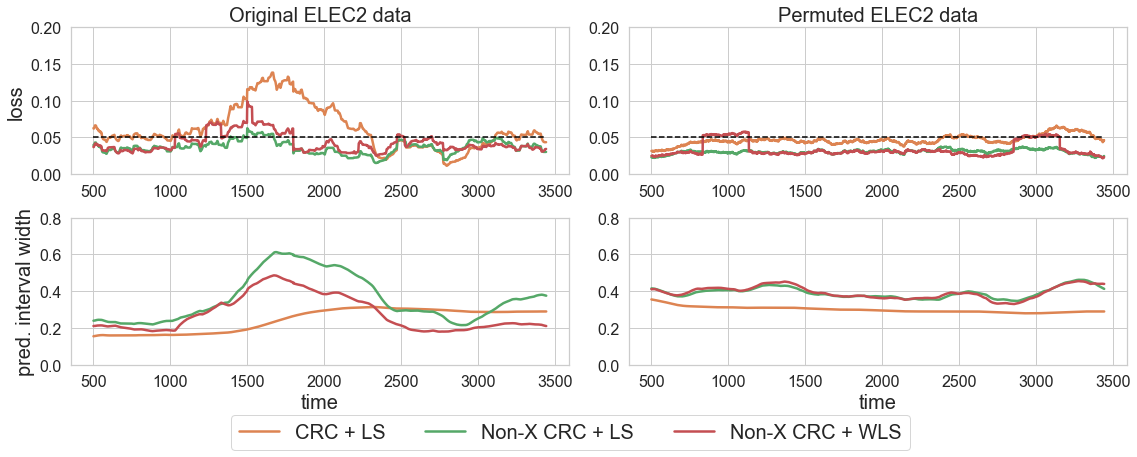

In [14]:


def rolling_avg(x,window):
    return np.convolve(x,np.ones(window)/window)[(window-1):-window]



# Set the Seaborn style
sns.set(style="whitegrid")
pastel_palette = sns.color_palette("deep")
font_size = 20
window = 300
# Define the number of rows and columns for subplots
num_rows = 2
num_cols = 2
lw=2.5
fs2 = 16

# Create a figure with subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 6))  # 2 rows, 3 columns


sm_loss_CP_LS = rolling_avg(loss_CRC_LS,window)
sm_loss_nexCP_LS = rolling_avg(loss_nexCRC_LS,window)
sm_loss_nexCP_WLS = rolling_avg(loss_nexCRC_WLS,window)

sm_width_CP_LS = rolling_avg(PI_width_CRC_LS,window)
sm_width_nexCP_LS = rolling_avg(PI_width_nexCRC_LS,window)
sm_width_nexCP_WLS = rolling_avg(PI_width_nexCRC_WLS,window)

sm_loss_CP_LS_perm = rolling_avg(loss_CRC_LS_perm,window)
sm_loss_nexCP_LS_perm = rolling_avg(loss_nexCRC_LS_perm,window)
sm_loss_nexCP_WLS_perm = rolling_avg(loss_nexCRC_WLS_perm,window)

sm_width_CP_LS_perm = rolling_avg(PI_width_CRC_LS_perm,window)
sm_width_nexCP_LS_perm = rolling_avg(PI_width_nexCRC_LS_perm,window)
sm_width_nexCP_WLS_perm = rolling_avg(PI_width_nexCRC_WLS_perm,window)


axes[0, 0].plot(np.arange(train_lag + window, N), sm_loss_CP_LS, color=pastel_palette[1], linewidth=lw, label="CRC + LS")
axes[0, 0].plot(np.arange(train_lag + window, N), sm_loss_nexCP_LS, color=pastel_palette[2], linewidth=lw, label="Non-X CRC + LS")
axes[0, 0].plot(np.arange(train_lag + window, N), sm_loss_nexCP_WLS, color=pastel_palette[3], linewidth=lw, label="Non-X CRC + WLS")
axes[0, 0].hlines(alpha_risk, xmin=train_lag + window, xmax=N, linestyles='--',  colors='black')
axes[0, 0].set_title("Original ELEC2 data", fontsize=font_size)
axes[0, 0].set_ylabel('loss', fontsize=font_size)
#axes[0, i].set_xlabel('Time')
axes[0, 0].set_ylim([0, 0.2])
ticks = axes[0, 0].yaxis.get_major_ticks()
for tick in ticks:
    tick.label.set_fontsize(fs2)
ticks = axes[0, 0].xaxis.get_major_ticks()
for tick in ticks:
    tick.label.set_fontsize(fs2)
#axes[0, i].legend(['CRC', 'Non-X CRC'])

axes[0, 1].plot(np.arange(train_lag + window, N), sm_loss_CP_LS_perm, color=pastel_palette[1], linewidth=lw, label="CRC + LS")
axes[0, 1].plot(np.arange(train_lag + window, N), sm_loss_nexCP_LS_perm, color=pastel_palette[2], linewidth=lw, label="Non-X CRC + LS")
axes[0, 1].plot(np.arange(train_lag + window, N), sm_loss_nexCP_WLS_perm, color=pastel_palette[3], linewidth=lw, label="Non-X CRC + WLS")
axes[0, 1].hlines(alpha_risk, xmin=train_lag + window, xmax=N, linestyles='--', colors='black')
axes[0, 1].set_title("Permuted ELEC2 data", fontsize=font_size)
# axes[0, 1].set_ylabel('loss', fontsize=font_size)
# axes[0, 1].set_xlabel('Time')
axes[0, 1].set_ylim([0, 0.2])
ticks = axes[0, 1].yaxis.get_major_ticks()
for tick in ticks:
    tick.label.set_fontsize(fs2)
ticks = axes[0, 1].xaxis.get_major_ticks()
for tick in ticks:
    tick.label.set_fontsize(fs2)
#axes[0, i].legend(['CRC', 'Non-X CRC'])

axes[1, 0].plot(np.arange(train_lag + window, N), sm_width_CP_LS, color=pastel_palette[1], linewidth=lw, label="CRC + LS")
axes[1, 0].plot(np.arange(train_lag + window, N), sm_width_nexCP_LS, color=pastel_palette[2], linewidth=lw, label="Non-X CRC + LS")
axes[1, 0].plot(np.arange(train_lag + window, N), sm_width_nexCP_WLS, color=pastel_palette[3], linewidth=lw, label="Non-X CRC + WLS")
# axes[0, 1].hlines(alpha, xmin=train_lag + window, xmax=N, linestyles='--', colors='black')
# axes[1, 0].set_title("Original ELEC2 data", fontsize=font_size)
axes[1, 0].set_ylabel('pred. interval width', fontsize=font_size)
axes[1, 0].set_xlabel('time', fontsize=font_size)
axes[1, 0].set_ylim([0, 0.8])
ticks = axes[1, 0].yaxis.get_major_ticks()
for tick in ticks:
    tick.label.set_fontsize(fs2)
ticks = axes[1, 0].xaxis.get_major_ticks()
for tick in ticks:
    tick.label.set_fontsize(fs2)

axes[1, 1].plot(np.arange(train_lag + window, N), sm_width_CP_LS_perm, color=pastel_palette[1], linewidth=lw, label="CRC + LS")
axes[1, 1].plot(np.arange(train_lag + window, N), sm_width_nexCP_LS_perm, color=pastel_palette[2], linewidth=lw, label="Non-X CRC + LS")
axes[1, 1].plot(np.arange(train_lag + window, N), sm_width_nexCP_WLS_perm, color=pastel_palette[3], linewidth=lw, label="Non-X CRC + WLS")
# axes[1, 1].hlines(alpha, xmin=train_lag + window, xmax=N, linestyles='--', colors='black')
# axes[1, 1].set_title("Permuted ELEC2 data", fontsize=font_size)
# axes[1, 1].set_ylabel('Predicted interval width: 2λ', fontsize=font_size)
axes[1, 1].set_xlabel('time', fontsize=font_size)
axes[1, 1].set_ylim([0, 0.8])
ticks = axes[1, 1].yaxis.get_major_ticks()
for tick in ticks:
    tick.label.set_fontsize(fs2)
ticks = axes[1, 1].xaxis.get_major_ticks()
for tick in ticks:
    tick.label.set_fontsize(fs2)


# Create a shared legend below the subplots
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.08), fontsize=font_size)   # Adjust the legend location and columns as needed

# Adjust spacing between subplots
plt.tight_layout()

# Save the plot
# plt.savefig('nonx-CRC-simulations/tl_combined_plot_a_' + str(alpha) + '_classes_' + str(nclasses) +'_rho_' + str(rho)+ '_ntrial_' + str(ntrial) +'_window_' + str(window) + '.png', dpi=500, bbox_inches='tight')

# Show the plot
plt.show()




In [18]:
[['ELEC2 data','',''],\
['      ','mean loss  ','mean width'],\
['CRC+LS    ',np.mean(loss_CRC_LS),np.mean(PI_width_CRC_LS)],\
['nexCRC+LS ',np.mean(loss_nexCRC_LS),np.mean(PI_width_nexCRC_LS)],\
['nexCRC+WLS',np.mean(loss_nexCRC_WLS),np.mean(PI_width_nexCRC_WLS)],\
['CRC+LS p',np.mean(loss_CRC_LS_perm),np.mean(PI_width_CRC_LS)],\
['nexCRC+LS p',np.mean(loss_nexCRC_LS_perm),np.mean(PI_width_nexCRC_LS)],\
['nexCRC+WLS p',np.mean(loss_nexCRC_WLS_perm),np.mean(PI_width_nexCRC_WLS)]]



[['ELEC2 data', '', ''],
 ['      ', 'mean loss  ', 'mean width'],
 ['CRC+LS    ', 0.06189616999988783, 0.24288840937114675],
 ['nexCRC+LS ', 0.03698514788023926, 0.3553390875462393],
 ['nexCRC+WLS', 0.04258743271963429, 0.271750924784217],
 ['CRC+LS p', 0.0461819885476904, 0.24288840937114675],
 ['nexCRC+LS p', 0.030369336397988275, 0.3553390875462393],
 ['nexCRC+WLS p', 0.03306062716979359, 0.271750924784217]]